Check the quality of the embeddings here

In [113]:
import ast
import json
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

model = Doc2Vec.load("doc2vec.maven_artifact.200.100.2.5.20")
libs = pd.read_csv("../export/GroupArtifact.csv").set_index("id")
rules = pd.read_csv("../test_data/ground_truth.csv", sep=";")
rules["fromIds"] = rules["fromIds"].apply(lambda x: ast.literal_eval(x))
rules["toIds"] = rules["toIds"].apply(lambda x: ast.literal_eval(x))

lib_ids = set([i for a in rules["fromIds"] for i in a] + [i for a in rules["toIds"] for i in a])
lib_set = set(rules["fromLibrary"]) | set(rules["toLibrary"])
ga_set = set(map(lambda x: libs["groupId"][x] + ":" + libs["artifactId"][x], lib_ids))
rules_set = set(rules["fromLibrary"] + " " + rules["toLibrary"])

In [109]:
test_libs = ["org.json:json", "com.alibaba:fastjson", "org.postgresql:postgresql", "commons-io:commons-io", "org.apache.opennlp:opennlp-tools",
            "log4j:log4j"]
for l in test_libs:
    print(l, model.wv.most_similar_cosmul(l))

org.json:json [('org.infrastructurebuilder:ibcore-files', 0.7129988074302673), ('org.infrastructurebuilder:ibfiles', 0.7067476511001587), ('org.infrastructurebuilder:core-test-keyset-import-pom', 0.7053126692771912), ('org.infrastructurebuilder:iblstream-api', 0.7036569714546204), ('com.onarandombox:MultiverseCore', 0.6615700125694275), ('${project.groupId}:common-legacy-api', 0.6395952105522156), ('softsimples:service', 0.6375991106033325), ('com.ryanfuse:crgrep-core', 0.6365022659301758), ('softsimples:activator', 0.6360591650009155), ('com.jagrosh:jda-utilities', 0.6339341402053833)]
com.alibaba:fastjson [('com.alibaba:dubbo', 0.696138322353363), ('com.treefinance.saas:grap-server-share', 0.6820258498191833), ('cn.jpush.api:jpush-client', 0.6785820722579956), ('org.mybatis.generator:mybatis-generator-core', 0.6772429943084717), ('org.apache.lucene:lucene-analyzers-smartcn', 0.6731269955635071), ('com.aliyun.oss:aliyun-sdk-oss', 0.6711127161979675), ('com.googlecode.json-simple:json-

In [100]:
[name for name in ga_set if name not in model.wv]

['cz.advel.jbullet:jbullet',
 'org.dellroad:leveldb',
 'org.apache.mahout:mahout',
 'net.sourceforge.jwebunit:jwebunit',
 'com.netflix.Nicobar:nicobar-manager',
 'org.keycloak:keycloak-appliance-dist-all',
 'com.paypal.sdk:permissionssdk',
 'org.kie.modules:org-apache-mina',
 'org.dellroad:leveldb-api',
 'de.ebf:spring-granular-permissions',
 'be.cyberelf.nanoxml:nanoxml',
 'org.powermock:powermock-api',
 'org.javabits.jgrapht:jgrapht',
 'nu.validator:htmlparser',
 'net.htmlparser:jericho-html',
 'io.paradoxical:json-path',
 'com.liferay:org.hibernate.core',
 'org.slf4j:slf4j-site',
 'org.wisdom-framework:sqlite-jdbc',
 'io.github.benas:xstream',
 'org.apache.opennlp:opennlp',
 'org.jasig.portal:uPortal-security-permissions',
 'com.facebook.airlift:concurrent',
 'org.elasticsearch:elasticsearch-core',
 'org.atteo.moonshine:hibernate',
 'de.weltraumschaf.commons:jcommander',
 'com.liferay:com.liferay.application.list.user.personal.site.permissions',
 'de.softwareforge:dumbster']

$$
Quality = \frac{1}{|R|}\sum_{(l_1, l_2) \in R}\cos(l_1, l_2) - \frac{1}{|\bar{R}|}\sum_{(l_1, l_2) \in \bar{R}}\cos(l_1, l_2)
$$

In [112]:
from numpy import dot
from numpy.linalg import norm
def idx2ga(idx):
    return libs["groupId"][idx] + ":" + libs["artifactId"][idx]
score = 0
ga_true_positive = set()
ga_true_negative = set()
list_of_libraries = rules["fromIds"] + rules["toIds"]
#print(list_of_libraries)
for l in list_of_libraries:
    for x in l:
        for y in l:
            if x != y and idx2ga(x) in model.wv and idx2ga(y) in model.wv:
                ga_true_positive.add((idx2ga(x), idx2ga(y)))
for x in ga_set:
    for y in ga_set:
        if (x, y) not in ga_true_positive:
            if x != y and x in model.wv and y in model.wv:
                ga_true_negative.add((x, y))
#print(len(ga_true_positive), len(ga_true_negative))
#print(list(ga_true_positive)[0:10], list(ga_true_negative)[0:10])
r1 = 1 / len(ga_true_positive) 
r2 = 1 / len(ga_true_negative)
for l1, l2 in ga_true_positive:
    score += model.wv.distance(l1, l2) * r1
for l1, l2 in ga_true_negative:
    score -= model.wv.distance(l1, l2) * r2
print("Score: ", score)

Score:  -0.04515084768513361


|  Data  |   Parameters     | Quality  |
|--------|------------------|----------|
| (0, 4) | 200.100.2.1.20   | -0.05033 |
| (0, 4) | 200.100.5.1.20   | -0.04515 |
| (0, 4) | 200.100.2.5.20   | -0.03154 |
| (0, 4) | 100.100.10.1.20  | -0.05737 |
| (0, 4) | 100.2.10.100.20  | -0.07002 |

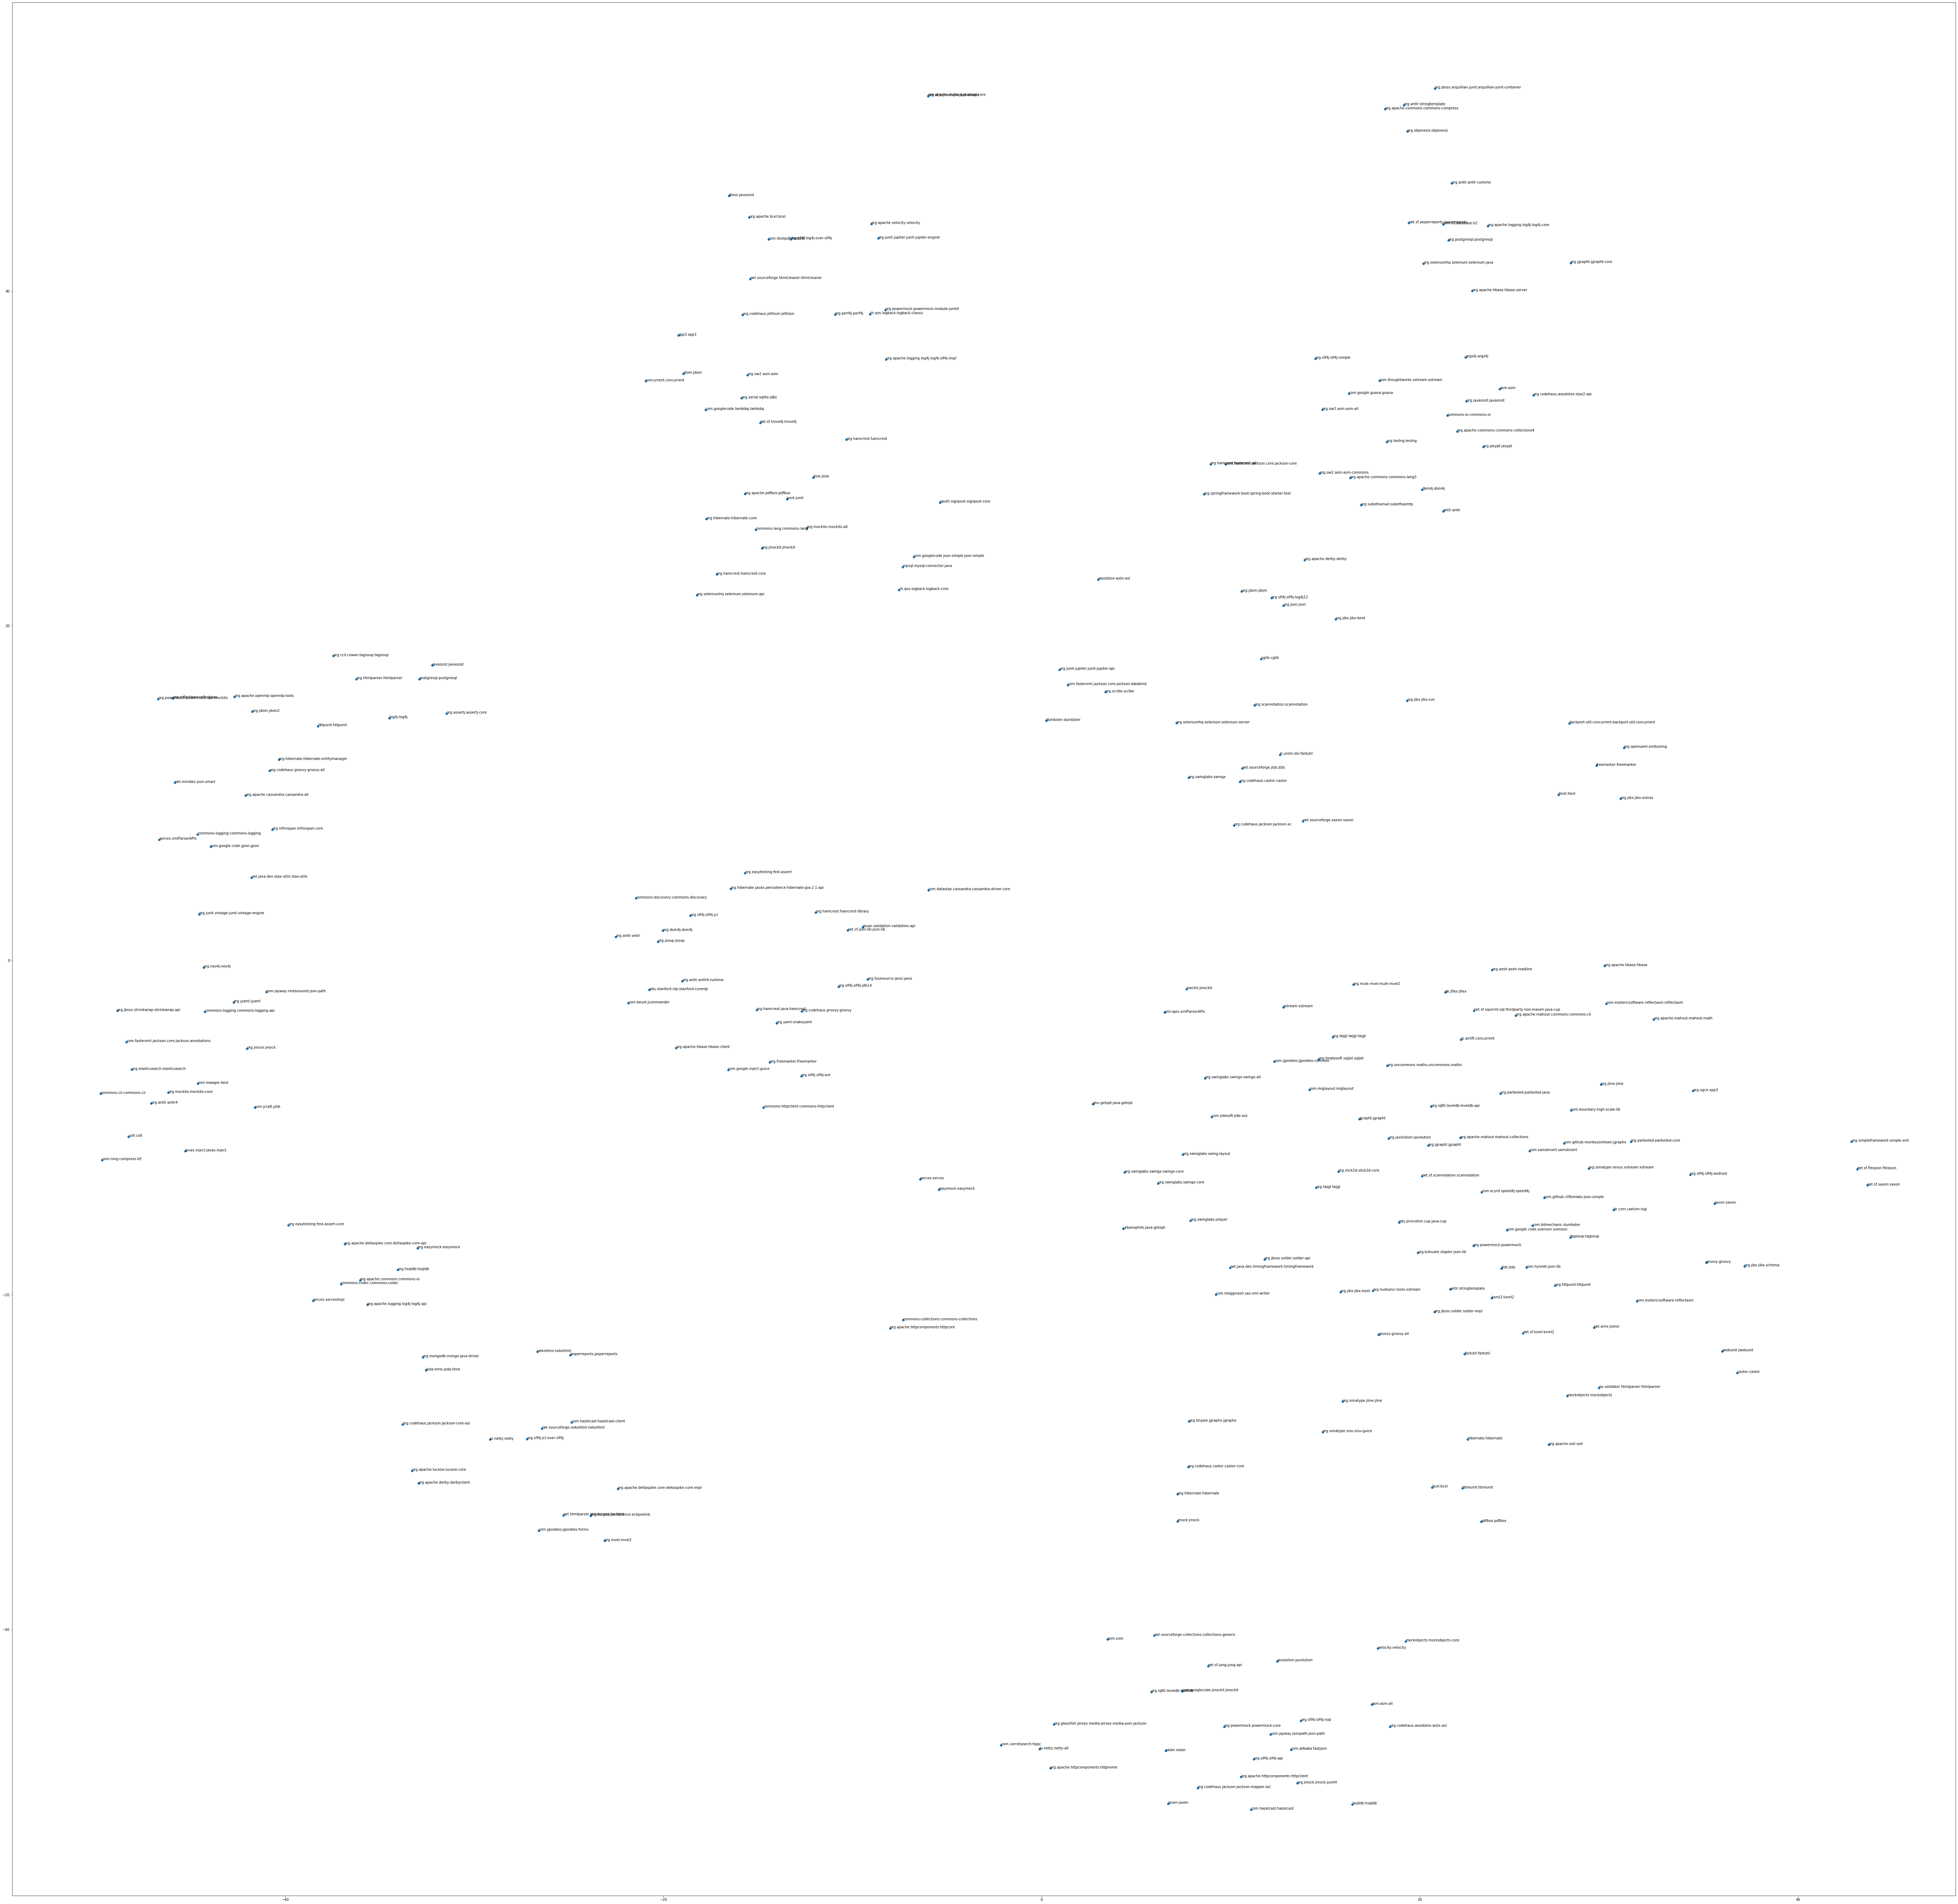

In [104]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
X_name = [name for name in ga_set if name in model.wv]
X = np.array([model.wv.get_vector(name) for name in X_name])
X_embedded = TSNE(n_components=2, perplexity=5).fit_transform(X)
fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter([x[0] for x in X_embedded], [x[1] for x in X_embedded])
for i, x in enumerate(X_embedded):
    ax.annotate(X_name[i], (x[0], x[1]))
fig.savefig("tsne.png")